# Why Prediction Metrics Fail for Causal Models

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A5 | Notebook 1 of 2**

This notebook demonstrates why standard prediction metrics like R²
are dangerous for evaluating causal models, even on randomized data.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

---

## 1. Intuition {#intuition}

### The Misconception

**Common belief**: "With randomized data, we can evaluate a causal model
by its predictive performance (R²) on the test set."

**Reality**: This is **wrong** and can lead to terrible causal model selection!

### Why R² Can Mislead

**DGP decomposition**:
$$Y = g(X) + f(T, X) + \epsilon$$

where:
- $g(X)$ = effect of covariates on outcome (no treatment)
- $f(T, X)$ = treatment effect (may vary with X)

**Problem**: If $|g(X)| >> |f(T, X)|$, a model can achieve high R² 
by predicting $g(X)$ while completely ignoring $f(T, X)$!

### Visual Example

| Model | Predicts | R² | Causal Quality |
|-------|----------|----|-----------------|
| M1 | g(X) well, f(T,X) poorly | 0.92 | ❌ Bad |
| M2 | g(X) poorly, f(T,X) well | 0.08 | ✅ Good |

**Paradox**: The better predictor (M1) is a worse causal model!

```
★ Insight ─────────────────────────────────────────────────────
Prediction answers: "What is Y?"
Causal inference answers: "How does Y change with T?"

These are fundamentally different questions.
High R² means nothing for the second question.
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Additive Outcome Model

General decomposition:
$$Y_i = g(X_i) + f(T_i, W_i) + \epsilon_i$$

where:
- $X$ = covariates affecting $Y$ directly (not through $T$)
- $W$ = covariates affecting treatment heterogeneity
- $T$ = treatment (randomized)
- $g(\cdot)$ = "nuisance" function
- $f(\cdot, \cdot)$ = causal function of interest

### 2.2 Prediction Variance Decomposition

Total outcome variance:
$$\text{Var}(Y) = \text{Var}(g(X)) + \text{Var}(f(T, W)) + \text{Var}(\epsilon) + \text{Cross-terms}$$

If $\text{Var}(g(X)) >> \text{Var}(f(T, W))$, then:
- High R² ≈ predicting $g(X)$ well
- Causal component $f(T, W)$ contributes little to R²

### 2.3 R² for Causal Models

**Problem formalization**:

Let $\hat{M}$ be an estimator that outputs $\hat{Y} = \hat{M}(T, X, W)$.

$$R^2 = 1 - \frac{\sum_i (Y_i - \hat{M}(T_i, X_i, W_i))^2}{\sum_i (Y_i - \bar{Y})^2}$$

**Key insight**: R² rewards predicting $Y$ accurately, but:
- A model predicting $\hat{Y} = \hat{g}(X_i)$ can have high R²
- This model has $\hat{f}(T, W) = 0$ (no treatment effect!)

### 2.4 CATE Evaluation

For CATE, we need to evaluate $\hat{\tau}(X) = \hat{E}[Y(1) - Y(0) | X]$.

**Problem**: We never observe $Y(1) - Y(0)$ for any individual.

**Fundamental challenge**: Cannot directly compute prediction error for CATE!

$$\text{MSE}_{CATE} = E[(\hat{\tau}(X) - \tau(X))^2]$$

This is **unobservable** because $\tau(X) = E[Y(1) - Y(0)|X]$ requires both potential outcomes.

```
★ Key Result ──────────────────────────────────────────────────
R² evaluates: Var(Ŷ - Y) / Var(Y)

We want to evaluate: Var(τ̂(X) - τ(X))

These are NOT equivalent because:
- Y = g(X) + τ(X)·T + ε
- Predicting Y well ≠ Estimating τ(X) well
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Simulated DGP

In [2]:
def generate_causal_data(n=100000, n_nuisance=20, n_heter=10, seed=42):
    """
    Generate data where nuisance features dominate prediction
    but don't affect treatment heterogeneity.
    
    DGP: Y = g(X) + f(T, W) + ε
    
    - X: Features that predict Y strongly but DON'T interact with T
    - W: Features that ONLY affect Y through interaction with T
    
    Parameters
    ----------
    n : int
        Sample size
    n_nuisance : int
        Number of nuisance features (X)
    n_heter : int
        Number of heterogeneity features (W)
    seed : int
        Random seed
        
    Returns
    -------
    pd.DataFrame
        Data with columns X_0...X_{n_nuisance-1}, W_0...W_{n_heter-1}, T, Y
    """
    np.random.seed(seed)
    
    # Nuisance features X (high predictive power, no treatment interaction)
    X = np.random.normal(1, 10, (n, n_nuisance))
    nuisance_coefs = np.random.uniform(-1, 1, (n_nuisance, 1))
    
    # Heterogeneity features W (only affect Y through T)
    W = np.random.normal(1, 10, (n, n_heter))
    heter_coefs = np.random.uniform(-1, 1, (n_heter, 1))
    
    # Treatment (randomized)
    T = np.random.normal(10, 2, (n, 1))
    
    # Outcome
    # g(X) = 20 * X @ nuisance_coefs (LARGE effect)
    # f(T, W) = T + T * W @ heter_coefs (smaller effect)
    g_X = 20 * X @ nuisance_coefs
    f_T_W = T + T * (W @ heter_coefs)
    
    Y = np.random.normal(g_X + f_T_W, 0.1)
    
    # Create DataFrame
    X_cols = [f'X_{i}' for i in range(n_nuisance)]
    W_cols = [f'W_{i}' for i in range(n_heter)]
    
    df = pd.DataFrame(X, columns=X_cols)
    df = pd.concat([df, pd.DataFrame(W, columns=W_cols)], axis=1)
    df['T'] = T.flatten()
    df['Y'] = Y.flatten()
    
    return df, X_cols, W_cols

# Generate data
df, X_cols, W_cols = generate_causal_data(n=100000, n_nuisance=20, n_heter=10)

print(f"Data shape: {df.shape}")
print(f"Nuisance features (X): {len(X_cols)}")
print(f"Heterogeneity features (W): {len(W_cols)}")
print(f"\nVariance decomposition:")
print(f"  Var(Y): {df['Y'].var():.2f}")

Data shape: (100000, 32)
Nuisance features (X): 20
Heterogeneity features (W): 10

Variance decomposition:
  Var(Y): 243766.63


In [3]:
# Train/test split
train, test = train_test_split(df, test_size=0.5, random_state=42)
print(f"Train: {len(train)}, Test: {len(test)}")

Train: 50000, Test: 50000


### Train Two Models

In [4]:
# Model 1: Uses nuisance features X (high R², but wrong for CATE)
formula_m1 = "Y ~ T * (" + " + ".join(X_cols) + ")"
m1 = smf.ols(formula_m1, data=train).fit()

# Model 2: Uses heterogeneity features W (low R², but correct for CATE)
formula_m2 = "Y ~ T * (" + " + ".join(W_cols) + ")"
m2 = smf.ols(formula_m2, data=train).fit()

print("Model 1 (uses X, nuisance features):")
print(f"  Formula: Y ~ T * (X_0 + ... + X_19)")
print(f"  Train R²: {m1.rsquared:.4f}")

print("\nModel 2 (uses W, heterogeneity features):")
print(f"  Formula: Y ~ T * (W_0 + ... + W_9)")
print(f"  Train R²: {m2.rsquared:.4f}")

Model 1 (uses X, nuisance features):
  Formula: Y ~ T * (X_0 + ... + X_19)
  Train R²: 0.8558

Model 2 (uses W, heterogeneity features):
  Formula: Y ~ T * (W_0 + ... + W_9)
  Train R²: 0.1433


### Evaluate with R² (MISLEADING)

In [5]:
# Test set R²
r2_m1 = r2_score(test['Y'], m1.predict(test))
r2_m2 = r2_score(test['Y'], m2.predict(test))

print("Test Set R² Comparison:")
print("-" * 50)
print(f"Model 1 (nuisance features X): R² = {r2_m1:.4f}")
print(f"Model 2 (heterogeneity features W): R² = {r2_m2:.4f}")
print("\n⚠️  Based on R², Model 1 appears MUCH better!")
print("   But this is MISLEADING for causal inference...")

Test Set R² Comparison:
--------------------------------------------------
Model 1 (nuisance features X): R² = 0.8572
Model 2 (heterogeneity features W): R² = 0.1455

⚠️  Based on R², Model 1 appears MUCH better!
   But this is MISLEADING for causal inference...


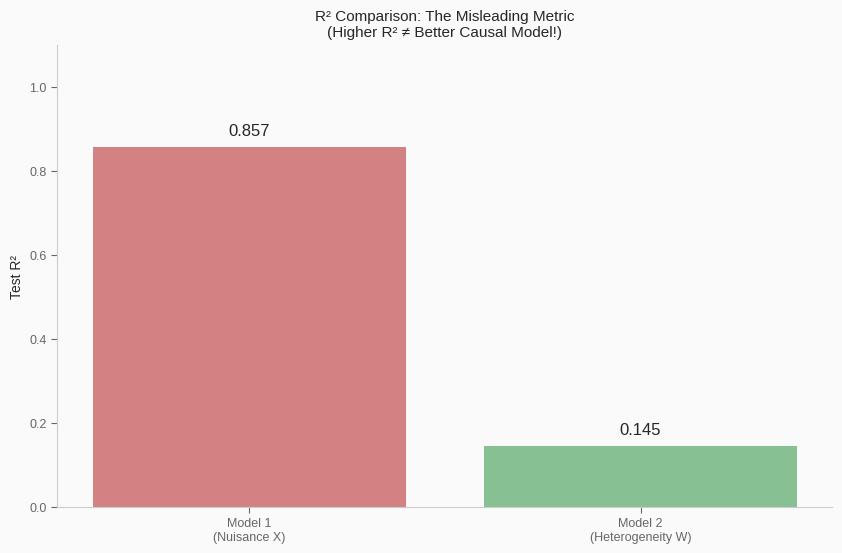

In [6]:
# Visualize the paradox
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Model 1\n(Nuisance X)', 'Model 2\n(Heterogeneity W)']
r2_values = [r2_m1, r2_m2]

colors = [COLORS['red'], COLORS['green']]
bars = ax.bar(models, r2_values, color=colors, alpha=0.7)

# Add value labels
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12)

ax.set_ylabel('Test R²')
ax.set_title('R² Comparison: The Misleading Metric\n'
             '(Higher R² ≠ Better Causal Model!)')
ax.set_ylim(0, 1.1)
apply_tufte_style(ax)
plt.show()

---

## 4. Implementation {#implementation}

### Compute CATE Predictions

In [7]:
def get_cate_predictions(model, data, t_col='T', delta=1):
    """
    Compute CATE predictions from a linear model.
    
    For linear models: CATE ≈ M(X, W, T) - M(X, W, T - delta)
    
    Parameters
    ----------
    model : statsmodels fitted model
        Fitted OLS model
    data : pd.DataFrame
        Data to predict on
    t_col : str
        Treatment column name
    delta : float
        Treatment change for CATE computation
        
    Returns
    -------
    array
        CATE predictions
    """
    # Prediction at current T
    pred_t = model.predict(data)
    
    # Prediction at T - delta
    data_lower = data.copy()
    data_lower[t_col] = data_lower[t_col] - delta
    pred_t_lower = model.predict(data_lower)
    
    return pred_t - pred_t_lower

# Get CATE predictions
test_pred = test.copy()
test_pred['cate_m1'] = get_cate_predictions(m1, test)
test_pred['cate_m2'] = get_cate_predictions(m2, test)

print("CATE Predictions:")
print(f"  M1 mean CATE: {test_pred['cate_m1'].mean():.3f}")
print(f"  M2 mean CATE: {test_pred['cate_m2'].mean():.3f}")

CATE Predictions:
  M1 mean CATE: 1.955
  M2 mean CATE: 1.797


### Cumulative Elasticity Curve (Proper Evaluation)

In [8]:
def compute_elasticity(data, y_col, t_col):
    """
    Compute treatment elasticity (slope coefficient).
    
    Elasticity = Cov(Y, T) / Var(T)
    """
    y = data[y_col].values
    t = data[t_col].values
    
    cov = np.sum((t - t.mean()) * (y - y.mean()))
    var = np.sum((t - t.mean())**2)
    
    return cov / var


def cumulative_gain_curve(data, cate_col, y_col, t_col, min_periods=30, steps=100):
    """
    Compute cumulative elasticity curve.
    
    Orders units by predicted CATE (descending) and computes
    cumulative elasticity as more units are included.
    
    A good CATE model should have steeper curve (high CATE units first).
    
    Parameters
    ----------
    data : pd.DataFrame
        Data with CATE predictions
    cate_col : str
        Column with CATE predictions
    y_col : str
        Outcome column
    t_col : str
        Treatment column
    min_periods : int
        Minimum observations to start computing
    steps : int
        Number of points on curve
        
    Returns
    -------
    array
        Cumulative elasticity values
    """
    n = len(data)
    
    # Sort by predicted CATE (descending)
    ordered = data.sort_values(cate_col, ascending=False).reset_index(drop=True)
    
    # Points to evaluate
    n_rows = list(range(min_periods, n, n // steps)) + [n]
    
    # Compute cumulative elasticity at each point
    cum_elast = []
    for rows in n_rows:
        subset = ordered.head(rows)
        elast = compute_elasticity(subset, y_col, t_col)
        cum_elast.append(elast * (rows / n))  # Scale by proportion
    
    return np.array(cum_elast), np.array(n_rows) / n

# Compute curves
curve_m1, pct_m1 = cumulative_gain_curve(test_pred, 'cate_m1', 'Y', 'T')
curve_m2, pct_m2 = cumulative_gain_curve(test_pred, 'cate_m2', 'Y', 'T')

# Random baseline
overall_elast = compute_elasticity(test_pred, 'Y', 'T')

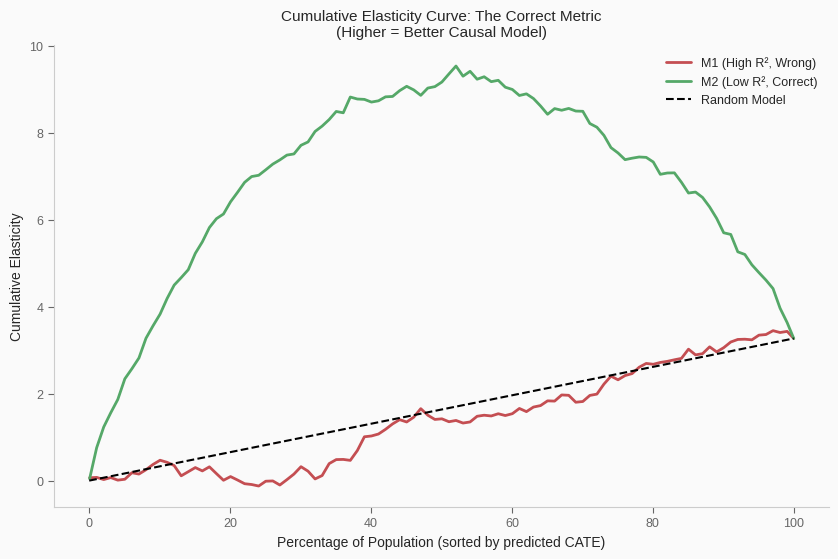


✅ Model 2 (low R²) is the BETTER causal model!
   Its curve is steeper, indicating better CATE ranking.


In [9]:
# Plot cumulative elasticity curves
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(pct_m1 * 100, curve_m1, color=COLORS['red'], linewidth=2, label='M1 (High R², Wrong)')
ax.plot(pct_m2 * 100, curve_m2, color=COLORS['green'], linewidth=2, label='M2 (Low R², Correct)')
ax.plot([0, 100], [0, overall_elast], 'k--', linewidth=1.5, label='Random Model')

ax.set_xlabel('Percentage of Population (sorted by predicted CATE)')
ax.set_ylabel('Cumulative Elasticity')
ax.set_title('Cumulative Elasticity Curve: The Correct Metric\n'
             '(Higher = Better Causal Model)')
ax.legend()
apply_tufte_style(ax)
plt.show()

print("\n✅ Model 2 (low R²) is the BETTER causal model!")
print("   Its curve is steeper, indicating better CATE ranking.")

### Comparison Table

In [10]:
# Summary comparison
comparison = pd.DataFrame({
    'Metric': ['Test R²', 'Cumulative Gain (AUC)', 'Correct for CATE?'],
    'Model 1 (X)': [f'{r2_m1:.4f}', f'{np.trapezoid(curve_m1, pct_m1):.4f}', '❌ No'],
    'Model 2 (W)': [f'{r2_m2:.4f}', f'{np.trapezoid(curve_m2, pct_m2):.4f}', '✅ Yes']
})

print("\nModel Comparison:")
print("-" * 60)
print(comparison.to_string(index=False))
print("\n" + "-" * 60)
print("Conclusion: R² is MISLEADING for causal model evaluation!")


Model Comparison:
------------------------------------------------------------
               Metric Model 1 (X) Model 2 (W)
              Test R²      0.8572      0.1455
Cumulative Gain (AUC)      1.3912      6.8849
    Correct for CATE?        ❌ No       ✅ Yes

------------------------------------------------------------
Conclusion: R² is MISLEADING for causal model evaluation!


```
★ Key Takeaway ────────────────────────────────────────────────
Why R² Fails for Causal Models:

1. **R² rewards predicting Y**, not τ(X)
2. **Nuisance g(X) can dominate** outcome variance
3. **A model ignoring treatment** can have high R²

Better alternatives:
- Cumulative elasticity curves
- Residualized outcome R² (next notebook)
- CATE-specific metrics (Tau-Risk, T-learner MSE)
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Why can't we just use R² to evaluate causal models on RCT data?

<details>
<summary>Solution</summary>

**The decomposition argument**:

Outcome can be written as:
$$Y = g(X) + \tau(X) \cdot T + \epsilon$$

where $g(X)$ is nuisance and $\tau(X)$ is treatment effect heterogeneity.

**R² evaluates**:
$$R^2 = 1 - \frac{\sum(Y - \hat{Y})^2}{\sum(Y - \bar{Y})^2}$$

A model can achieve high R² by:
- Accurately predicting $g(X)$ (large variance contribution)
- Completely ignoring $\tau(X)$ (small variance contribution)

**Example**:
- Model A: Predicts $\hat{Y} = \hat{g}(X)$, ignores treatment → R² = 0.92
- Model B: Predicts $\hat{Y} = \hat{\tau}(X) \cdot T$, ignores nuisance → R² = 0.08

Model A has higher R² but is useless for CATE estimation!

**Bottom line**: R² measures prediction accuracy, not causal accuracy.

</details>

### Q2: What is the cumulative elasticity curve and why is it better?

<details>
<summary>Solution</summary>

**Definition**:

1. Sort units by predicted CATE (descending)
2. For top k% of units, compute treatment elasticity:
   $$\text{Elasticity}_k = \frac{\text{Cov}(Y, T)}{\text{Var}(T)} \bigg|_{\text{top } k\%}$$
3. Plot elasticity × k/100 vs k

**Why it works**:

- If model correctly identifies high-CATE units:
  - Top k% has higher treatment effect than average
  - Curve rises steeply initially
  
- If model is random:
  - Top k% has same effect as overall
  - Curve follows 45° line

**Interpretation**:
- **Steeper curve** = Better CATE ranking
- **Area under curve** = Overall CATE quality

**Key advantage**: Uses actual treatment effects (from Y and T), not predicted ones!

</details>

### Q3: What's the fundamental problem with evaluating CATE models?

<details>
<summary>Solution</summary>

**The fundamental problem of causal inference**:

We want to evaluate:
$$\text{MSE}_{CATE} = E[(\hat{\tau}(X) - \tau(X))^2]$$

But $\tau(X) = E[Y(1) - Y(0) | X]$ is **never observed**!

For any individual, we see:
- $Y(1)$ if treated
- $Y(0)$ if control
- Never both

**Consequences**:

1. **Cannot compute direct CATE error**
2. **Must use indirect metrics**:
   - Cumulative gain curves (uses group-level effects)
   - Residualized outcome prediction
   - Plug-in estimators (T-learner, X-learner)

3. **Simulation is gold standard**:
   - Only in simulations do we know true $\tau(X)$
   - Can compute actual CATE MSE

</details>

### Q4: In practice, how do you evaluate a CATE model without true effects?

<details>
<summary>Solution</summary>

**Practical evaluation strategies**:

1. **Cumulative gain curves** (this notebook)
   - Sort by predicted CATE, check if actual effects align
   - Works on randomized data

2. **Residualized outcome prediction** (next notebook)
   - Remove $g(X)$ from outcome
   - Evaluate R² on $\tilde{Y} = Y - \hat{g}(X)$

3. **Calibration plots**
   - Bin by predicted CATE
   - Check actual elasticity in each bin

4. **Uplift metrics** (marketing applications)
   - Qini curves
   - Uplift at percentiles

5. **Cross-validation with causal loss**
   - R-loss: $\sum(\tilde{Y} - \hat{\tau}(X) \cdot \tilde{T})^2$

**Best practice**: Use multiple metrics, not just one!

</details>

### Q5: When IS R² appropriate in causal inference?

<details>
<summary>Solution</summary>

**R² is appropriate for**:

1. **Nuisance model evaluation**
   - Evaluating $\hat{g}(X)$ in DML
   - Evaluating propensity score model
   - Goal IS prediction accuracy

2. **Outcome prediction (not causal)**
   - Forecasting Y regardless of treatment
   - Risk scoring applications

3. **When treatment effect is large**
   - If $\text{Var}(\tau(X) \cdot T) >> \text{Var}(g(X))$
   - Then high R² implies good treatment modeling
   - Rare in practice

**R² is NOT appropriate for**:

1. **CATE model selection**
2. **Treatment effect heterogeneity ranking**
3. **Comparing causal models**

**Rule of thumb**: If you're asking "how does Y change with T?", don't use R².

</details>

---

## 6. References {#references}

[^1]: Athey, S., & Imbens, G. (2016). Recursive Partitioning for Heterogeneous 
      Causal Effects. *PNAS*.

[^2]: Nie, X., & Wager, S. (2021). Quasi-Oracle Estimation of Heterogeneous 
      Treatment Effects. *Biometrika*.

[^3]: Chernozhukov, V., et al. (2018). Generic Machine Learning Inference on 
      Heterogeneous Treatment Effects. *Econometrica*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Prediction Metrics for Causal Models.